In [8]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import data_processing as dp
from zoneinfo import ZoneInfo
from statsmodels.tsa.stattools import pacf



from collections import defaultdict

In [2]:
events_df = dp.load_events()

Loading Events : 2013
Loading Events : 2014
Loading Events : 2015
Loading Events : 2016
Loading Events : 2017
Loading Events : 2018
Loading Events : 2019
Loading Events : 2020
Loading Events : 2021
Loading Events : 2022
Loading Events : 2023
Loading Events : 2024
Loaded 6005103 events


In [3]:
importlib.reload(dp)

filtered_events_df = dp.filter_events(events_df, 
                                      CauseCodes=['U1', 'U2', 'U3', 'D1', 'D2', 'D3', 'SF'], 
                                      filter_fuel=False, 
                                      exclude_states=['Other','Mexico','South America'], 
                                      include_states=None,
                                      add_fuel_failure=False)

Filtering events by cause codes...
Kept 839971 events out of 6005103 (13.99%) after filtering by cause codes.


Adding state and region: 100%|██████████| 834847/834847 [01:12<00:00, 11449.59it/s]


In [4]:
units_start_end = dp.get_units_start_end()

Loading Performances : 2013
Loading Performances : 2014
Loading Performances : 2015
Loading Performances : 2016
Loading Performances : 2017
Loading Performances : 2018
Loading Performances : 2019
Loading Performances : 2020
Loading Performances : 2021
Loading Performances : 2022
Loading Performances : 2023
Loading Performances : 2024
Loaded 1035652 events


100%|██████████| 9305/9305 [00:09<00:00, 945.99it/s] 


In [5]:
# Mapping from U.S. state / Canadian province abbreviations to representative IANA time zones
STATE_TIMEZONE = {
    # --- U.S. ---
    "AL": "America/Chicago", "AK": "America/Anchorage", "AZ": "America/Phoenix",
    "AR": "America/Chicago", "CA": "America/Los_Angeles", "CO": "America/Denver",
    "CT": "America/New_York", "DE": "America/New_York", "DC": "America/New_York",
    "FL": "America/New_York", "GA": "America/New_York", "HI": "Pacific/Honolulu",
    "ID": "America/Boise", "IL": "America/Chicago", "IN": "America/Indiana/Indianapolis",
    "IA": "America/Chicago", "KS": "America/Chicago", "KY": "America/New_York",
    "LA": "America/Chicago", "ME": "America/New_York", "MD": "America/New_York",
    "MA": "America/New_York", "MI": "America/Detroit", "MN": "America/Chicago",
    "MS": "America/Chicago", "MO": "America/Chicago", "MT": "America/Denver",
    "NE": "America/Chicago", "NV": "America/Los_Angeles", "NH": "America/New_York",
    "NJ": "America/New_York", "NM": "America/Denver", "NY": "America/New_York",
    "NC": "America/New_York", "ND": "America/Chicago", "OH": "America/New_York",
    "OK": "America/Chicago", "OR": "America/Los_Angeles", "PA": "America/New_York",
    "RI": "America/New_York", "SC": "America/New_York", "SD": "America/Chicago",
    "TN": "America/Chicago", "TX": "America/Chicago", "UT": "America/Denver",
    "VT": "America/New_York", "VA": "America/New_York", "WA": "America/Los_Angeles",
    "WV": "America/New_York", "WI": "America/Chicago", "WY": "America/Denver",

    # --- Canada ---
    "AB": "America/Edmonton", "BC": "America/Vancouver", "MB": "America/Winnipeg",
    "NB": "America/Moncton", "NL": "America/St_Johns", "NS": "America/Halifax",
    "NT": "America/Yellowknife", "NU": "America/Iqaluit", "ON": "America/Toronto",
    "PE": "America/Halifax", "QC": "America/Montreal", "SK": "America/Regina",
    "YT": "America/Whitehorse",
}

# Load state abbreviations
state_files = "../data/ghcn-states.txt"
state2abv = {}
with open(state_files, "r") as f:
    for line in f:
        line = line.strip().split()
        state2abv[' '.join(line[1:])] = line[0]

In [6]:
technology_of_interest = 'Gas Turbine/Jet Engine (Simple Cycle Operation)'

In [7]:
per_gen_ts = defaultdict(pd.DataFrame)

for unit_id, events_unit in tqdm(filtered_events_df.groupby('UnitID')):
    # Store the transitions for this unit
    unit_capacity = {"Datetime_local":[], # at the start of each hour
                    "Capacity_%":[]}

    # Unit metadata
    unit_geo_state = events_unit["State"].iloc[0]
    unit_technology = events_unit["UnitTypeCodeName"].iloc[0]
    if unit_technology != technology_of_interest:
        continue
    state_abv = state2abv.get(unit_geo_state.upper(), None)
    tz_name = STATE_TIMEZONE.get(state_abv)

    if tz_name is None:
        print(f"⚠️ Unknown timezone for {unit_geo_state}, skipping unit {unit_id}")
        continue

    tz = ZoneInfo(tz_name)

    # Get start and end time for this unit
    start_time_unit_local = pd.Timestamp(units_start_end.loc[
                                                        units_start_end['UnitID'] == unit_id, 'First_Operation_Date'
                                                      ].values[0])
    end_time_unit_local = pd.Timestamp(units_start_end.loc[
                                                        units_start_end['UnitID'] == unit_id, 'Last_Operation_Date'
                                                    ].values[0])

    current_time_local = start_time_unit_local
    events_unit = events_unit.sort_values('EventStartDT')
    last_state = 'A'
    
    for _, event in events_unit.iterrows():
        event_start_local = event['EventStartDT'].replace(minute=0, second=0, microsecond=0)
        event_end_local = event['EventEndDT'].replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
        state_during_event = event["EventTypeCode"]

        # Simplify event type
        if state_during_event.startswith('D'):
            state_during_event = 'D'
        elif state_during_event.startswith('U'):
            state_during_event = 'U'
        elif state_during_event == 'SF':
            if last_state != 'A':
                state_during_event = last_state # Startup failure treated as outage if the unit was not available before
            else:
                continue # skip startup failure if the unit was available before
        
        if state_during_event == 'A':
            capacity_event = 100
        elif state_during_event == 'U':
            capacity_event = 0
        elif state_during_event == 'D':
            np.random.seed(0)  # For reproducibility
            capacity_event = np.random.uniform(10, 100)  # Random capacity between 10% and 100%


        # Record 'A' states until the event starts
        while current_time_local < event_start_local:
            unit_capacity["Datetime_local"].append(current_time_local)
            unit_capacity["Capacity_%"].append(100)

            # unit_transitions_data["Initial_gen_state"].append(last_state)
            # unit_transitions_data["Final_gen_state"].append('A')
            current_time_local += pd.Timedelta(hours=1)
            # last_state = 'A'
        
        # Record states during the event
        while current_time_local < event_end_local:
            unit_capacity["Datetime_local"].append(current_time_local)
            unit_capacity["Capacity_%"].append(capacity_event)

            # unit_transitions_data["Datetime_local"].append(current_time_local)
            # unit_transitions_data["Initial_gen_state"].append(last_state)
            # unit_transitions_data["Final_gen_state"].append(state_during_event)
            current_time_local += pd.Timedelta(hours=1)
            last_state = state_during_event

    # Fill 'A' states until end of operation
    while current_time_local <= end_time_unit_local:
        unit_capacity["Datetime_local"].append(current_time_local)
        unit_capacity["Capacity_%"].append(100)
        # unit_transitions_data["Datetime_local"].append(current_time_local)
        # unit_transitions_data["Initial_gen_state"].append(last_state)
        # unit_transitions_data["Final_gen_state"].append('A')
        current_time_local += pd.Timedelta(hours=1)
        last_state = 'A'

   # --- Create DataFrame and convert local → UTC ---
    unit_capacity_df = pd.DataFrame(unit_capacity)

    # Localize to state timezone and drop invalid (nonexistent) times during DST jump
    unit_capacity_df["Datetime_UTC"] = (
    pd.to_datetime(unit_capacity_df["Datetime_local"])
    .dt.tz_localize(tz, nonexistent="NaT", ambiguous="NaT")   # use .dt accessor
    .dt.tz_convert("UTC")
    )
    unit_capacity_df = unit_capacity_df.dropna(subset=["Datetime_UTC"])

    per_gen_ts[unit_id] = unit_capacity_df.set_index("Datetime_UTC").sort_index()

100%|██████████| 7166/7166 [11:08<00:00, 10.71it/s] 


In [9]:
def compute_pacf_per_unit(time_series_per_unit, max_lag=48):
    pacfs = {}
    for unit_id, unit_df in tqdm(time_series_per_unit.items(), desc="Computing PACF per unit"):
        y = unit_df["Capacity_%"].values
        y = np.asarray(y, dtype=float)
        y = y[np.isfinite(y)]
        if len(y) < max_lag + 10:
            continue
        pacfs[unit_id] = pacf(y, nlags=max_lag, method="ywm")
    return pacfs

In [19]:
def plot_average_pacf_paper(
    time_series_per_unit,
    max_lag=48,
    figsize=(7.0, 3.2),
    drop_lag0=True,
    ci_method="bootstrap",   # "bootstrap" or "se"
    n_boot=2000,
    seed=0,
    title="Average PACF of generator availability across units",
):
    pacfs = compute_pacf_per_unit(time_series_per_unit, max_lag)
    units = list(pacfs.keys())
    pacf_mat = np.vstack([pacfs[u] for u in units])  # shape (n_units, max_lag+1)

    mean_pacf = pacf_mat.mean(axis=0)

    # --- Uncertainty band for the mean across units ---
    if ci_method == "bootstrap":
        rng = np.random.default_rng(seed)
        idx = np.arange(pacf_mat.shape[0])
        boot_means = np.empty((n_boot, pacf_mat.shape[1]), dtype=float)
        for b in range(n_boot):
            samp = rng.choice(idx, size=len(idx), replace=True)
            boot_means[b] = pacf_mat[samp].mean(axis=0)
        lo = np.quantile(boot_means, 0.025, axis=0)
        hi = np.quantile(boot_means, 0.975, axis=0)
        band_label = "95% bootstrap CI"
    elif ci_method == "se":
        se = pacf_mat.std(axis=0, ddof=1) / np.sqrt(pacf_mat.shape[0])
        lo = mean_pacf - 1.96 * se
        hi = mean_pacf + 1.96 * se
        band_label = "95% CI (normal approx.)"
    else:
        raise ValueError("ci_method must be 'bootstrap' or 'se'")

    lags = np.arange(pacf_mat.shape[1])

    if drop_lag0:
        lags = lags[1:]
        mean_pacf = mean_pacf[1:]
        lo = lo[1:]
        hi = hi[1:]

    fig, ax = plt.subplots(figsize=figsize)

    # Subtle grid + clean spines
    ax.grid(True, axis="y", alpha=0.25, linewidth=0.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # CI band
    # ax.fill_between(lags, lo, hi, alpha=0.18, linewidth=0, label=band_label)

    # Mean PACF as lollipops (stem-like, but with nicer control)
    ax.vlines(lags, 0, mean_pacf, linewidth=1.4, alpha=0.9)
    ax.scatter(lags, mean_pacf, s=28, alpha=0.95, color='tab:orange', label="Mean PACF")

    # Zero line
    ax.axhline(0, linewidth=1.0, color="black", alpha=0.8)

    ax.set_xlabel("Lag (hours)")
    ax.set_ylabel("Partial autocorrelation")
    ax.set_title(title)

    # Ticks: fewer, cleaner
    ax.set_xlim(lags.min() - 0.5, lags.max() + 0.5)
    ax.set_xticks(np.arange(0 if not drop_lag0 else 1, max_lag + 1, 6))
    ax.tick_params(axis="both", labelsize=10)

    # Legend (only because we have meaningful labels now)
    ax.legend(frameon=True, loc="upper right")

    fig.tight_layout()
    plt.show()

Computing PACF per unit:   2%|▏         | 35/2235 [00:01<01:20, 27.43it/s]/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
Computing PACF per unit:   5%|▍         | 104/2235 [00:03<01:21, 26.00it/s]/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
Computing PACF per unit:  50%|████▉     | 1108/2235 [00:42<00:39, 28.42it/s]/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
Computing PACF per unit:  82%|████████▏ | 1832/2235 [01:09<00:12, 32.67it/s]/Us

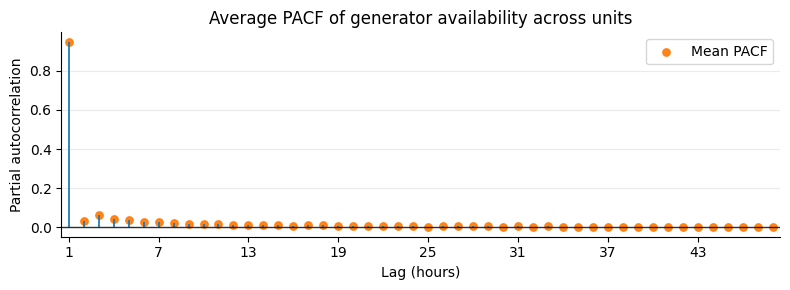

In [21]:
plot_average_pacf_paper(per_gen_ts, max_lag=48, figsize=(8,3))